# 角点检测

# 1. 角点检测原理

① 沿着水平方向、竖直方向，一个变化比较平稳，一个变化比较迅速，那它就是一个边界。

② 无论是沿着水平方向，还是沿着水平方向，变化都比较明显，则它是角点。

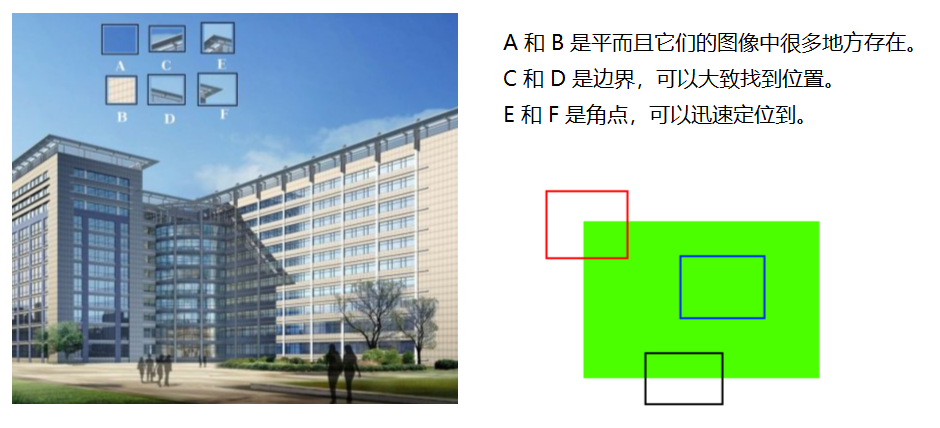

③ 平移前后的灰度值的变化情况，来判断该像素点是否是角点。

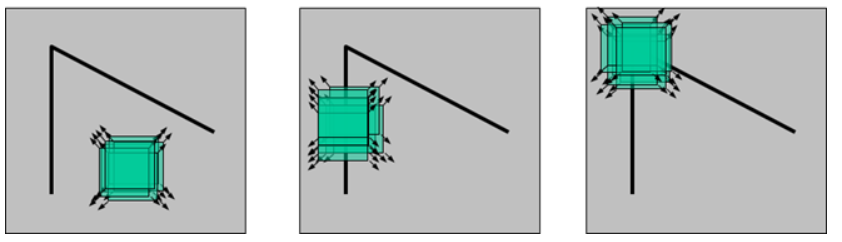

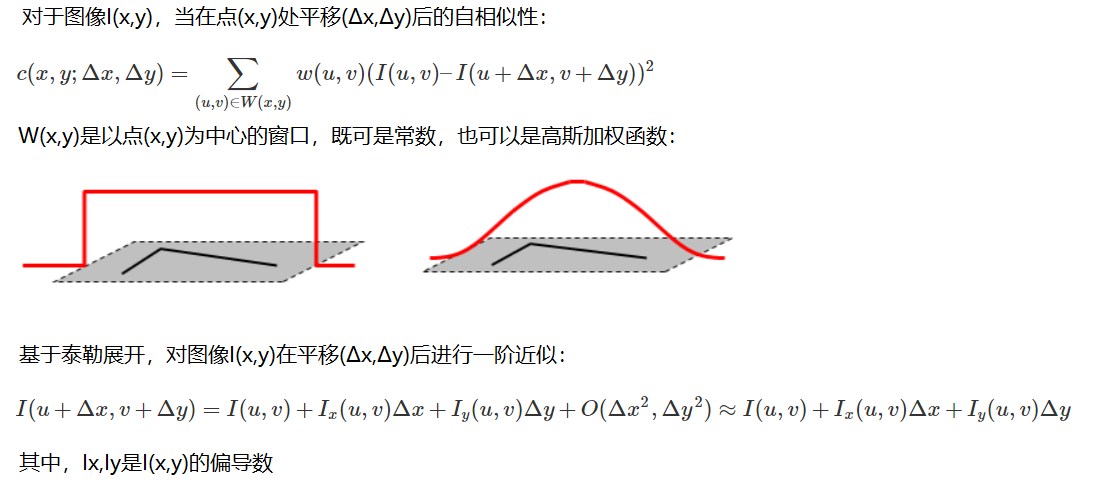

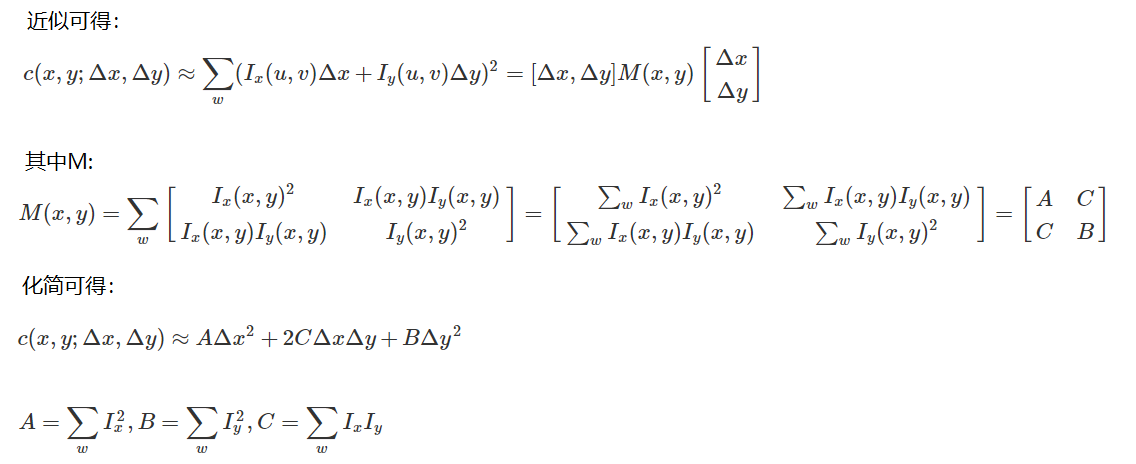

# Harris 角点检测核心知识点与公式详解

Harris 角点检测是由 Chris Harris 和 Mike Stephens 在 1988 年提出的一种经典算子。它彻底解决了如何让计算机通过数学手段识别图像“拐角”的问题。

---

## 1. 角点检测的直观原理

我们可以把计算机观察图像的过程，想象成透过一个极小的**滑动窗口**（放大镜）去观察画面。当我们在图像上滑动这个窗口时，会遇到以下三种情况：

1.  **平坦区域 (Flat Region)**：窗口内是一片纯色。无论窗口朝哪个方向移动，窗口内的图像看起来都没什么变化。
2.  **边界 (Edge)**：沿着水平或竖直方向，一个变化平稳，一个变化迅速。想象窗口卡在垂直线上：上下滑动窗口，画面不变（平稳）；左右滑动，画面瞬间变色（迅速）。
3.  **角点 (Corner)**：无论是水平方向还是竖直方向，变化都非常明显。想象窗口放在十字交叉点上，向任何方向移动，窗口内的像素明暗都会剧烈改变。

---

## 2. Harris 角点检测数学公式详解

为了让计算机实现上述逻辑，Harris 算法将其拆解为三个数学步骤：

### 第一步：计算窗口移动带来的“差异量” $E(u,v)$

我们要计算当窗口移动一个微小距离 $(u, v)$ 时，窗口内像素总和的差异程度。

**核心公式：**
$$E(u,v) = \sum_{x,y} w(x,y) \cdot [I(x+u, y+v) - I(x,y)]^2$$

**🧠 公式详细解释：**
* **$(x,y)$**：滑动窗口内各个像素点的坐标。
* **$w(x,y)$**：**窗口函数**（权重）。通常使用高斯函数，即越靠近窗口中心的像素权重越大。
* **$I(x,y)$**：窗口在原位置时，像素点的灰度值。
* **$I(x+u, y+v)$**：窗口移动 $(u,v)$ 距离后，对应位置的新灰度值。
* **$[\dots]^2$**：平方项。保证差值总是正数（变亮或变暗都算变化），且能放大显著的变化量。
* **$E(u,v)$**：最终的变化能量。值越大，说明移动窗口后画面变化越剧烈。

---

### 第二步：利用泰勒展开引入矩阵 $M$

为了不需要穷举所有移动方向，算法利用泰勒展开式进行近似推导，将公式简化为矩阵乘法形式：

**近似公式：**
$$E(u,v) \approx [u, v] \cdot M \cdot \begin{bmatrix} u \\ v \end{bmatrix}$$

**自相关矩阵 $M$：**
$$M = \sum_{x,y} w(x,y) \begin{bmatrix} I_x^2 & I_x I_y \\ I_x I_y & I_y^2 \end{bmatrix}$$

**🧠 公式详细解释：**
* **$I_x$**：图像在水平方向的**梯度**（相邻像素亮度差）。
* **$I_y$**：图像在竖直方向的**梯度**。
* **矩阵 $M$ 的物理意义**：它就像一个“变化方向雷达”，综合统计了窗口内所有像素在 $x$ 和 $y$ 方向上的剧烈程度。

---

### 第三步：特征值分析与角点响应函数 $R$

通过求解矩阵 $M$ 的两个特征值 $\lambda_1$ 和 $\lambda_2$，可以判断区域属性：
* $\lambda_1, \lambda_2$ 都很小 $\rightarrow$ **平坦区域**。
* 一个大，一个小 $\rightarrow$ **边界 (Edge)**。
* $\lambda_1, \lambda_2$ 都很大 $\rightarrow$ **角点 (Corner)**！

为了节省算力，Harris 提出了**角点响应函数 $R$**：

**核心公式：**
$$R = \det(M) - k \cdot (\operatorname{trace}(M))^2$$

**🧠 公式详细解释：**
* **$\det(M)$**：矩阵的行列式。数学上等于 $\lambda_1 \times \lambda_2$。
* **$\operatorname{trace}(M)$**：矩阵的迹。数学上等于 $\lambda_1 + \lambda_2$。
* **$k$**：经验常数，通常取 `0.04` 到 `0.06`。

---

## 💡 最终判定逻辑

计算机计算出每个像素点的 $R$ 值后，根据其正负和大小进行分类：

1.  **$R$ 为大的正数**：该点是**角点**。
2.  **$R$ 为负数**：该点是**边界**。
3.  **$R$ 的绝对值很小**：该点是**平坦区域**。

**代码对应：**
在 OpenCV 代码中，`dst > 0.01 * dst.max()` 的操作就是在寻找整张图中 $R$ 值最高的那一批像素点，并将它们标记为红色角点。

# 2. harris角点检测

① harris角点检测函数：cv2.cornerHarris() 
 - img：数据类型为 ﬂoat32 的入图像。
 - blockSize：角点检测中指定区域的大小。
 - ksize：Sobel求导中使用的窗口大小。常用 3。 
 - k：取值参数为 [0,04,0.06]。常用 0.04。

In [2]:
import cv2 # 导入 OpenCV 库。作用：提供图像处理的核心功能
import numpy as np # 导入 NumPy 库。作用：处理图像对应的矩阵数据

# 语法：cv2.imread(path)。作用：从指定路径读取图像。返回一个 (H, W, 3) 的三维数组
img = cv2.imread('01_Picture/17_Chessboard.jpg')    

# 作用：打印图像的维度（高、宽、通道数）。维度变化：无
print('img.shape:', img.shape)

# 语法：cv2.cvtColor(src, code)。作用：将彩色图像转为灰度图。
# 理由：Harris 角点检测基于亮度梯度，不需要颜色信息。维度变化：(H, W, 3) -> (H, W)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 语法：cv2.cornerHarris(src, blockSize, ksize, k)
# 参数：blockSize (2) 是检测邻域大小；ksize (3) 是 Sobel 算子核大小，用于算梯度；k (0.04) 是响应函数权重系数
# 作用：计算每个像素的角点响应值 R。维度变化：输出 dst 为 (H, W) 的得分矩阵
dst = cv2.cornerHarris(gray, 2, 3, 0.04) 

# 作用：查看响应值矩阵的维度。维度与灰度图一致
print('dst.shape:', dst.shape)    

# 语法：利用 NumPy 布尔索引进行条件筛选并赋值
# 作用：找出得分 R 大于最大值 1% 的所有像素位置，并将原图 img 在这些位置的颜色改为红色 [0,0,255]
# 数学原理：判定 R 值为正极大值的点为角点
img[dst > 0.01 * dst.max()] = [0, 0, 255] 

# 语法：cv2.imshow(winname, mat)。作用：在名为 'dst' 的窗口中显示标记后的图像
cv2.imshow('dst', img)

# 语法：cv2.waitKey(delay)。作用：等待键盘输入，0 表示无限期等待，直到按键发生。防止窗口闪退
cv2.waitKey(0)

# 作用：关闭所有由 OpenCV 创建的窗口，释放内存资源
cv2.destroyAllWindows()

img.shape: (512, 512, 3)
dst.shape: (512, 512)
